In [191]:
# Importing necessary modules and libraries

# Enum class for creating enumerations
from enum import Enum, auto

# Module for working with dates and times
from datetime import datetime

# Subplots module for creating subplots in Plotly
from plotly.subplots import make_subplots

# Plotly graph objects for creating interactive plots
import plotly.graph_objects as go

# Pandas for data manipulation and analysis
import pandas as pd

# NumPy for numerical operations
import numpy as np

# Requests for making HTTP requests
import requests

# Operating system dependent functionality
import os

# Plotly Express for simple syntax high-level interface
import plotly.express as px

In [192]:
# Reading a CSV file into a Pandas DataFrame
df = pd.read_csv("dataset.csv")

# Dropping the 'Unnamed: 0' column from the DataFrame
df = df.drop('Unnamed: 0', axis=1)

# Displaying the first 10 rows of the DataFrame
df.head(10)


,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,5274,08/07/2018,2266,17,27.4,44,1.7,2000,14.0,1.17,0.0,0.0,Yes
1,1185,19/01/2018,648,8,-2.5,50,1.0,1281,-11.5,0.00,0.0,0.0,Yes
2,6473,27/08/2018,886,16,24.7,85,1.2,1143,22.0,0.99,0.0,0.0,Yes
3,602,26/12/2017,127,1,-1.5,62,1.3,2000,-7.8,0.00,0.0,0.0,Yes
4,5656,24/07/2018,735,15,35.8,47,2.2,1029,22.7,1.51,0.0,0.0,Yes
5,3516,26/04/2018,930,11,18.1,42,2.7,1112,4.9,2.17,0.0,0.0,Yes
6,5240,07/07/2018,567,7,19.6,57,1.6,2000,10.8,0.42,0.0,0.0,Yes
7,2413,11/03/2018,666,12,9.2,40,2.6,592,-3.7,2.47,0.0,0.0,Yes
8,2463,13/03/2018,705,14,18.3,43,2.2,1509,5.4,2.43,0.0,0.0,Yes
9,3398,21/04/2018,1315,13,24.6,10,2.7,2000,-9.0,3.31,0.0,0.0,Yes


In [193]:
# Getting the list of column names from the DataFrame
columns = df.columns.tolist()

# Creating a list of snake-cased column names as per your specified order
snake_cased_columns = ['id',
                       'date', 'rented_bike_count', 'hour',
                       'temperature', 'humidity', 'wind_speed', 'visibility',
                       'dew_point_temperature', 'solar_radiation', 'rainfall',
                       'snowfall', 'functioning_day']

# Creating a dictionary to map snake-cased column names to the original column names
cols = {snake_cased_columns[i]: columns[i] for i in range(len(columns))}

# Displaying the dictionary that maps snake-cased columns to original columns
cols


{'id': 'ID',
 'date': 'Date',
 'rented_bike_count': 'Rented Bike Count',
 'hour': 'Hour',
 'temperature': 'Temperature(°C)',
 'humidity': 'Humidity(%)',
 'wind_speed': 'Wind speed (m/s)',
 'visibility': 'Visibility (10m)',
 'dew_point_temperature': 'Dew point temperature(°C)',
 'solar_radiation': 'Solar Radiation (MJ/m2)',
 'rainfall': 'Rainfall(mm)',
 'snowfall': 'Snowfall (cm)',
 'functioning_day': 'Functioning Day'}

Get Holiday API

In [194]:
def get_holidays(year, country_code):
    """
    Retrieves public holidays for a specific year and country code using an API.

    Parameters:
    - year (int): The year for which holidays are to be retrieved.
    - country_code (str): The country code specifying the country for which holidays are to be retrieved.

    Returns:
    - holidays (list): A list of dictionaries representing public holidays, where each dictionary contains
      information such as 'date', 'localName', 'name', and 'countryCode'.
    """
    # Constructing the API URL with the specified year and country code
    url = f'https://date.nager.at/api/v2/PublicHolidays/{year}/{country_code}'
    
    # Making a GET request to the API and getting the JSON response
    response = requests.get(url)
    
    # Parsing the JSON response to retrieve the list of public holidays
    holidays = response.json()
    
    # Returning the list of public holidays
    return holidays


Spring (봄 - Bom): Approximate Date Range: March to May

Summer (여름 - Yeoreum): Approximate Date Range: June to August

Autumn (가을 - Gaeul): Approximate Date Range: September to November

Winter (겨울 - Gyeoul): Approximate Date Range: December to February

In [195]:
from enum import Enum, auto

# Enum class representing the seasons
class Season(Enum):
    WINTER = auto()
    SPRING = auto()
    SUMMER = auto()
    AUTUMN = auto()

def get_season(month: int, to_numeric=False):
    """
    Gets the season based on the month.

    Parameters:
    - month (int): The month for which to determine the season (1 to 12).
    - to_numeric (bool): If True, returns the numeric value of the season; otherwise, returns the season name.

    Returns:
    - season_name (str or int): The name or numeric value of the season.
    
    Raises:
    - ValueError: If the provided month is not in the valid range (1 to 12).
    """
    # Mapping of months to seasons
    season_mapping = {
        12: Season.WINTER,
        1: Season.WINTER,
        2: Season.WINTER,
        3: Season.SPRING,
        4: Season.SPRING,
        5: Season.SPRING,
        6: Season.SUMMER,
        7: Season.SUMMER,
        8: Season.SUMMER,
        9: Season.AUTUMN,
        10: Season.AUTUMN,
        11: Season.AUTUMN
    }

    # Check if the provided month is in the mapping
    if month in season_mapping:
        # Return the season name or numeric value based on the 'to_numeric' parameter
        return season_mapping[month].name if not to_numeric else season_mapping[month].value
    else:
        # Raise a ValueError if the provided month is not in the valid range
        raise ValueError(f"Invalid month: {month}")


In [196]:
from datetime import datetime

# Default date format used in the code
DF_DATETIME_FORMAT = "%d/%m/%Y"

def date(date_string, format=DF_DATETIME_FORMAT):
    """
    Parses a date string into a datetime object using the specified format.

    Parameters:
    - date_string (str): The date string to be parsed.
    - format (str): The format of the date string. Default is "%d/%m/%Y".

    Returns:
    - datetime_obj (datetime): A datetime object representing the parsed date.
    """
    return datetime.strptime(date_string, format)

def is_date_in_holidays(date, holiday_list):
    """
    Checks if a date is in the list of holidays.

    Parameters:
    - date (datetime): The date to check.
    - holiday_list (list): A list of datetime objects representing holidays.

    Returns:
    - is_in_holidays (bool): True if the date is in the list of holidays; False otherwise.
    """
    return date.strftime("%Y-%m-%d") in holiday_list

In [197]:
# Adding a new column "Season" based on the month of the "Date" column
df["Season"] = df["Date"].apply(lambda x: get_season(date(x).month))

# Convert the "Date" column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format=DF_DATETIME_FORMAT)

# Getting a list of holidays for 2018 and 2017 in South Korea and creating a new column "Holiday"
holidays_list = [holiday["date"] for holiday in get_holidays(2018, "KR") + get_holidays(2017, "KR")]
df["Holiday"] = df['Date'].dt.strftime("%Y-%m-%d").isin(holidays_list)

Convert and revert values

In [198]:
# Mapping 'Yes' to 1 and 'No' to 0 in the "functioning_day" column
df[cols['functioning_day']] = df[cols["functioning_day"]].map({'Yes': 1, 'No': 0})

# Mapping True to 1 and False to 0 in the "Holiday" column
df["Holiday"] = df["Holiday"].map({True: 1, False: 0})

# Converting the "Date" column to datetime objects with the specified format
df["Date"] = pd.to_datetime(df["Date"].dt.strftime(DF_DATETIME_FORMAT), format=DF_DATETIME_FORMAT)

Updating snake_case columns dictionary

In [199]:
# Getting the list of column names from the DataFrame
columns = df.columns.tolist()

# Creating a list of snake-cased column names as per your specified order
snake_cased_columns = ['id',
                       'date', 'rented_bike_count', 'hour',
                       'temperature', 'humidity', 'wind_speed', 'visibility',
                       'dew_point_temperature', 'solar_radiation', 'rainfall',
                       'snowfall', 'functioning_day', 'season', 'holiday']

# Creating a dictionary to map snake-cased column names to the original column names
cols = {snake_cased_columns[i]: columns[i] for i in range(len(columns))}

# Displaying the dictionary that maps snake-cased columns to original columns
cols

{'id': 'ID',
 'date': 'Date',
 'rented_bike_count': 'Rented Bike Count',
 'hour': 'Hour',
 'temperature': 'Temperature(°C)',
 'humidity': 'Humidity(%)',
 'wind_speed': 'Wind speed (m/s)',
 'visibility': 'Visibility (10m)',
 'dew_point_temperature': 'Dew point temperature(°C)',
 'solar_radiation': 'Solar Radiation (MJ/m2)',
 'rainfall': 'Rainfall(mm)',
 'snowfall': 'Snowfall (cm)',
 'functioning_day': 'Functioning Day',
 'season': 'Season',
 'holiday': 'Holiday'}

In [200]:
df.head()

,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Season,Holiday
0,5274,2018-07-08,2266,17,27.4,44,1.7,2000,14.0,1.17,0.0,0.0,1,SUMMER,0
1,1185,2018-01-19,648,8,-2.5,50,1.0,1281,-11.5,0.00,0.0,0.0,1,WINTER,0
2,6473,2018-08-27,886,16,24.7,85,1.2,1143,22.0,0.99,0.0,0.0,1,SUMMER,0
3,602,2017-12-26,127,1,-1.5,62,1.3,2000,-7.8,0.00,0.0,0.0,1,WINTER,0
4,5656,2018-07-24,735,15,35.8,47,2.2,1029,22.7,1.51,0.0,0.0,1,SUMMER,0


In [201]:
# Sorting the DataFrame by the "Date" and "Hour" columns
df = df.sort_values(by=["Date", "Hour"]).reset_index(drop=True)


In [202]:
# Checking the number of null values in each column of the DataFrame
null_counts = df.isnull().sum()

For features like 'Wind speed (m/s)', 'Rainfall(mm)', and 'Snowfall (cm)', filling with 0 might make sense if missing values indicate the absence of wind, rainfall, or snowfall at that specific time.
Filling with 0 can be appropriate when missing values represent a true absence of the variable rather than a data collection issue.

In [203]:
# Filling null values with 0 in each column using the apply method
df = df.apply(lambda col: col.fillna(0))

# Checking the data types of each column in the DataFrame
df.dtypes

ID                                    int64
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Functioning Day                       int64
Season                               object
Holiday                               int64
dtype: object

In [204]:
# Generating descriptive statistics for the DataFrame
df.describe()

,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Holiday
count,7008.000000,7008,7008.000000,7008.00000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000
mean,3504.500000,2018-04-25 12:00:00.000000256,691.503282,11.50000,13.123787,58.159532,1.743936,1420.027255,4.292166,0.590795,0.150842,0.074044,0.989726,0.034247
min,1.000000,2017-12-01 00:00:00,0.000000,0.00000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1752.750000,2018-02-11 18:00:00,191.000000,5.75000,1.800000,42.000000,0.900000,915.750000,-6.800000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3504.500000,2018-04-25 12:00:00,449.000000,11.50000,15.500000,57.000000,1.600000,1664.000000,6.800000,0.020000,0.000000,0.000000,1.000000,0.000000
75%,5256.250000,2018-07-07 06:00:00,1038.250000,17.25000,24.000000,74.000000,2.400000,1996.000000,16.500000,0.950000,0.000000,0.000000,1.000000,0.000000
max,7008.000000,2018-09-18 00:00:00,3556.000000,23.00000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.000000,1.000000,1.000000
std,2023.179676,NaN,652.017206,6.92268,13.008561,20.661100,1.076832,613.772399,14.192489,0.894654,1.164972,0.397460,0.100846,0.181875


# Visualization

In [205]:
# Creating a bar chart using Plotly Express
# Grouping the DataFrame by "Season," calculating the sum of "Rented Bike Count" for each season
# Resetting the index to make "Season" a regular column, and resetting the index again to create a new index
# The resulting DataFrame is used to create a bar chart with 'Season' on the x-axis and 'Rented Bike Count' on the y-axis
fig = px.bar(df.groupby("Season")["Rented Bike Count"].sum().reset_index().reset_index(), 
             x='Season', 
             y="Rented Bike Count", 
             title="Seasonal Distribution of Rented Bike Counts")

# Displaying the plot
fig.show()

In [206]:
# Grouping the DataFrame by "Date" and "Holiday," calculating the sum of "Rented Bike Count" for each day
day_grouped = df.groupby(["Date", "Holiday"])["Rented Bike Count"].sum().reset_index()

# Creating a bar chart using Plotly Express
# The x-axis represents the "Date," the y-axis represents the sum of "Rented Bike Count"
# The color parameter is used to distinguish between holiday and non-holiday days
fig = px.bar(day_grouped, 
             x="Date", 
             y="Rented Bike Count", 
             color=day_grouped['Holiday'].apply(lambda x: 'Holiday' if x == 1 else 'Non-holiday'), 
             title="Daily Rented Bike Count with Holiday Breakdown")

# Displaying the plot
fig.show()


In [207]:
# Grouping the DataFrame by "Hour," calculating the mean of "Rented Bike Count" for each hour
rented_per_hour = df.groupby("Hour")["Rented Bike Count"].mean().reset_index()

# Creating a line chart using Plotly Express
# The x-axis represents the "Hour," and the y-axis represents the mean of "Rented Bike Count"
fig = px.line(rented_per_hour, 
              x="Hour", 
              y="Rented Bike Count", 
              title="Analysis of Bicycle Rentals by Hour (Mean)")

# Displaying the plot
fig.show()


In [208]:
df.columns.tolist()

['ID',
 'Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Functioning Day',
 'Season',
 'Holiday']

In [209]:
# List of lists containing selected weather-related columns
selected_cols = [
    [cols["temperature"], cols["wind_speed"], cols["rainfall"]],
    [cols["humidity"], cols["visibility"], cols["dew_point_temperature"]],
    [cols["solar_radiation"]]
]

# Creating subplots using Plotly's make_subplots
fig = make_subplots(rows=3, cols=3)

# Looping through rows and columns to add line charts for selected weather metrics
for row in range(1, len(selected_cols)+1):
    col = 1
    for item in selected_cols[row-1]:
        # Grouping the DataFrame by the selected weather metric and calculating the mean of "Rented Bike Count"
        temp = df.groupby(item)["Rented Bike Count"].mean().reset_index()
        
        # Creating a line chart for the selected weather metric
        trace = go.Scatter(x=temp[item], y=temp['Rented Bike Count'], mode='lines', name=item)
        
        # Adding the trace to the subplot
        fig.add_trace(trace, row=row, col=col)
        
        # Updating y-axis title for specific subplot
        if (row, col) == (2, 1):
            fig.update_yaxes(title_text="Rented Bike Count", row=row, col=col)
        
        col += 1

# Updating the overall layout of the subplot
fig.update_layout(title='Weather Metrics and Their Impact on Bike Demand')

# Displaying the subplot
fig.show()

We can conclude that:
1. The demand for rented bikes is likely influenced by seasonal variations rather than holiday occurrences.
Weather metrics significantly affect the rented bike count.
2. The weather metrics have a substantial impact on the number of rented bikes.
    - The highest bike rental counts occur when the temperature is between 20°C and 35°C. This suggests that moderate and warm temperatures are favorable for bike rentals.
    - Higher wind speeds (> 6 m/s) are associated with the highest bike rental counts. This may indicate that some level of wind is not a deterrent for bike rentals and might even be preferred by riders.
    - Bike rentals peak when rainfall is either low (0-10 mm) or in a specific range (20-23 mm). This could imply that light rain or a specific intensity of rainfall might not significantly impact bike rental activities.
    - The highest bike rental counts are associated with low humidity levels (0-12%). Low humidity might be preferred by riders, potentially indicating more comfortable conditions.
    - Bike rentals peak when visibility is around 600 meters. This suggests that moderate visibility conditions are conducive to higher bike rental activities.
    - Bike rentals are highest when the dew point temperature is in the range of 0-18°C. This indicates that a moderate dew point temperature is favorable for bike rentals.
    - The highest bike rental counts are associated with solar radiation around 1.2 MJ/m2. This implies that a moderate level of solar radiation might be optimal for bike rentals.
3. Individuals tend to rent bikes mostly during the time intervals of 5-8 AM and 3-6 PM.

In [210]:
df.head()

,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Season,Holiday
0,1,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1,WINTER,0
1,2,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1,WINTER,0
2,3,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1,WINTER,0
3,4,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1,WINTER,0
4,5,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1,WINTER,0


In [211]:
# Adding a new "Season" column based on the month of the "Date" column (to representated numeric values)
df["Season"] = df["Date"].apply(lambda x: get_season(x.month, to_numeric=True))

# Displaying the first few rows of the DataFrame with the new "Season" column
df.head()


,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Season,Holiday
0,1,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1,1,0
1,2,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1,1,0
2,3,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1,1,0
3,4,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1,1,0
4,5,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1,1,0


In [212]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [213]:
# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Extract the month from the 'Date' column and create a new 'Month' column
df['Month'] = df['Date'].dt.month

# Apply the get_season function to the 'Month' column to create the 'Season' column
df['Season'] = df['Month'].apply(get_season)

# Print unique values in the 'Season' column before one-hot encoding
print("Unique values in 'Season' before one-hot encoding:", df['Season'].unique())

# One-hot encode the 'Season' column
df = pd.get_dummies(df, columns=['Season'])

# Print unique columns after one-hot encoding
print("Unique values in 'Season' after one-hot encoding:", df.filter(like='Season').columns)

Unique values in 'Season' before one-hot encoding: ['WINTER' 'SPRING' 'SUMMER' 'AUTUMN']
Unique values in 'Season' after one-hot encoding: Index(['Season_AUTUMN', 'Season_SPRING', 'Season_SUMMER', 'Season_WINTER'], dtype='object')


In [214]:
# List of features used for training and testing
features = ["Hour", "Holiday", 'Temperature(°C)']

# Target variable to predict
target = 'Rented Bike Count'

# Splitting the dataset into training and testing sets
# X_train and y_train represent the features and target variable in the training set
# X_test and y_test represent the features and target variable in the testing set
# The test set size is set to 20%, and a random seed (random_state) is used for reproducibility
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [215]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

# KNN model
knn_model = KNeighborsRegressor(n_neighbors=500)  # Can experiment with different values of n_neighbors
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

In [216]:
# Importing necessary metrics from scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate Random Forest model
print("Random Forest Metrics:")
print("MAE:", mean_absolute_error(y_test, rf_predictions))
print("RMSE:", mean_squared_error(y_test, rf_predictions, squared=False))

# Evaluate Gradient Boosting model
print("\nGradient Boosting Metrics:")
print("MAE:", mean_absolute_error(y_test, gb_predictions))
print("RMSE:", mean_squared_error(y_test, gb_predictions, squared=False))

# Evaluate KNN model
print("\nKNN Metrics:")
print("MAE:", mean_absolute_error(y_test, knn_predictions))
print("RMSE:", mean_squared_error(y_test, knn_predictions, squared=False))

# Evaluate Linear Regression model
print("\nLinear Regression Metrics:")
print("MAE:", mean_absolute_error(y_test, lr_predictions))
print("RMSE:", mean_squared_error(y_test, lr_predictions, squared=False))

Random Forest Metrics:
MAE: 238.23911726753985
RMSE: 398.38206606525875

Gradient Boosting Metrics:
MAE: 218.20597757723127
RMSE: 356.7079896584555

KNN Metrics:
MAE: 282.6566761768902
RMSE: 429.0331834999511

Linear Regression Metrics:
MAE: 365.36275001329335
RMSE: 498.99997277588454


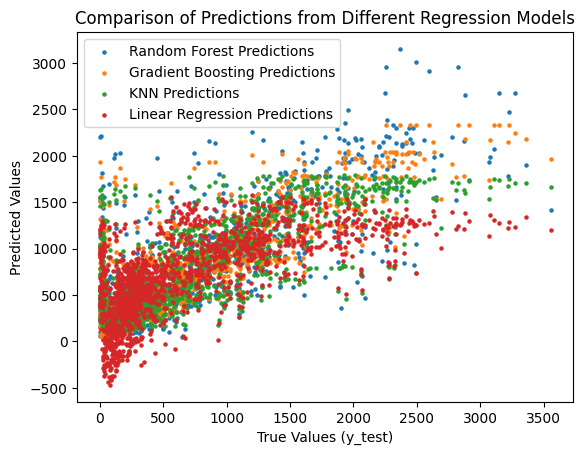

In [217]:
# Importing the necessary module for plotting
import matplotlib.pyplot as plt

# Creating a scatter plot to compare predictions from different regression models
plt.scatter(y_test, rf_predictions, label='Random Forest Predictions', s=5)
plt.scatter(y_test, gb_predictions, label='Gradient Boosting Predictions', s=5)
plt.scatter(y_test, knn_predictions, label='KNN Predictions', s=5)
plt.scatter(y_test, lr_predictions, label='Linear Regression Predictions', s=5)

# Displaying the legend to identify each set of predictions
plt.legend()

# Adding labels and title to the plot
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Comparison of Predictions from Different Regression Models')

# Displaying the plot
plt.show()

In [218]:
import numpy as np

def calculate_smape(y_true, y_pred):
    # Calculate the numerator: Absolute difference between predicted and true values
    numerator = np.abs(y_pred - y_true)
    
    # Calculate the denominator: 0.5 * (absolute values of predicted + true values)
    denominator = 0.5 * (np.abs(y_pred) + np.abs(y_true))
    
    # Calculate the percentage difference using element-wise division
    percentage_diff = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    
    # Calculate SMAPE as the mean of the percentage differences multiplied by 100
    smape = np.mean(percentage_diff) * 100
    
    return smape

In [219]:
# Calculate and print SMAPE for Random Forest model
smape_rf = calculate_smape(y_test, rf_predictions)
print(f'Random Forest SMAPE: {smape_rf:.2f}%')

# Calculate and print SMAPE for Gradient Boosting model
smape_gb = calculate_smape(y_test, gb_predictions)
print(f'Gradient Boosting SMAPE: {smape_gb:.2f}%')

# Calculate and print SMAPE for KNN model
smape_knn = calculate_smape(y_test, knn_predictions)
print(f'KNN SMAPE: {smape_knn:.2f}%')

# Calculate and print SMAPE for Linear Regression model
smape_lr = calculate_smape(y_test, lr_predictions)
print(f'Linear Regression SMAPE: {smape_lr:.2f}%')

Random Forest SMAPE: 41.64%
Gradient Boosting SMAPE: 38.53%
KNN SMAPE: 49.45%
Linear Regression SMAPE: 70.71%
